# Lab 3 – Predicting a Categorical Target and Evaluating Performance  

This lab builds on the Howell dataset explored in Lab 2.  
We will use several classification models to predict **gender** (`male` = 1, `female` = 0) from physical measurements.

### Objectives
- Prepare and explore the dataset  
- Engineer new features (BMI and BMI class)  
- Train and evaluate three classifiers  
  - Decision Tree  
  - Support Vector Machine (SVM)  
  - Neural Network (MLPClassifier)  
- Compare their performance and interpret results


## Section 1: Load and Inspect the Data

In this section, we:
1. Import all required Python libraries  
2. Load the Howell dataset (`Howell.csv`)  
3. Verify data structure, feature names, and basic statistics  

We will confirm:
- All expected columns are present (`height`, `weight`, `age`, `male`)  
- There are no missing values  
- The target variable `male` uses 0 for female and 1 for male


In [15]:
!pip install pandas numpy matplotlib seaborn scikit-learn



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\debcy\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [16]:
import pandas as pd
howell_full = pd.read_csv("Howell.csv", sep=";")
howell_full.head()


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


### Reflection 1

- What features are available in the Howell dataset?  
- Are there any missing values?  
- Is the dataset balanced between males and females?  
- Do the data types make sense for numerical analysis?


## Section 2: Data Exploration and Preparation

In this section, we compute new features (BMI and BMI class) and filter the dataset to include only adults (age > 18).
- **BMI (Body Mass Index)** is calculated using the metric formula:  
  \[
  BMI = \frac{10000 \times weight}{height^2}
  \]
- Then, we classify BMI values into categories:
  - Underweight (< 18.5)
  - Normal (18.5 – 24.9)
  - Overweight (25 – 29.9)
  - Obese (≥ 30)
- Finally, we separate adults and children for modeling.


In [17]:
import numpy as np

print("Shape:", howell_full.shape)
print("Columns:", list(howell_full.columns))
display(howell_full.head(3))

print("\nDTypes:")
print(howell_full.dtypes)

print("\n'male' value counts (0=female, 1=male):")
print(howell_full['male'].value_counts(dropna=False))

print("\nMissing values per column:")
print(howell_full.isna().sum())


Shape: (544, 4)
Columns: ['height', 'weight', 'age', 'male']


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0



DTypes:
height    float64
weight    float64
age       float64
male        int64
dtype: object

'male' value counts (0=female, 1=male):
male
0    287
1    257
Name: count, dtype: int64

Missing values per column:
height    0
weight    0
age       0
male      0
dtype: int64


In [19]:
# --- Section 2: Feature Engineering and Filtering ---

# 2.1 Compute BMI
def bmi(height, weight):
    return 10000 * weight / (height ** 2)

howell_full['bmi'] = bmi(howell_full['height'], howell_full['weight'])

# 2.2 Create BMI Class (Underweight, Normal, Overweight, Obese)
import numpy as np

def bmi_category(bmi):
    if bmi < 18.5: 
        return 'Underweight'
    elif bmi < 25: 
        return 'Normal'
    elif bmi < 30: 
        return 'Overweight'
    else: 
        return 'Obese'

vector_bmi_category = np.vectorize(bmi_category)
howell_full['bmi class'] = vector_bmi_category(howell_full['bmi'])

# Check distribution of BMI classes
print("BMI Class Counts:")
print(howell_full['bmi class'].value_counts())

# 2.3 Filter adults (age > 18)
over18 = howell_full['age'] > 18
howell_adults = howell_full[over18]
howell_children = howell_full[~over18]

print(f"\nAdults: {len(howell_adults)} | Children: {len(howell_children)}")


BMI Class Counts:
bmi class
Underweight    341
Normal         202
Overweight       1
Name: count, dtype: int64

Adults: 346 | Children: 198


In [21]:
# Quick verification of the adults subset
print("Preview of adult data:")
display(howell_adults.head())

print("\nSummary statistics for adult data:")
display(howell_adults.describe())


Preview of adult data:


,height,weight,age,male,bmi,bmi class
0,151.765,47.825606,63.0,1,20.764297,Normal
1,139.700,36.485807,63.0,0,18.695244,Normal
2,136.525,31.864838,65.0,0,17.095718,Underweight
3,156.845,53.041914,41.0,1,21.561444,Normal
4,145.415,41.276872,51.0,0,19.520384,Normal



Summary statistics for adult data:


,height,weight,age,male,bmi
count,346.000000,346.000000,346.000000,346.000000,346.000000
mean,154.644369,45.045543,41.539740,0.473988,18.774921
std,7.773564,6.455220,15.809304,0.500046,1.810977
min,136.525000,31.524644,19.000000,0.000000,13.751251
25%,148.590000,40.334251,29.000000,0.000000,17.491250
50%,154.305000,45.004831,40.000000,0.000000,18.664762
75%,160.655000,49.377742,51.000000,1.000000,19.997406
max,179.070000,62.992589,88.000000,1.000000,25.798565


### Reflection 2  

- Why is it important to separate adults from children before modeling?  
- What can the BMI Class distribution tell us about this population?  
- Do any BMI categories appear more common than others? What might that suggest about the dataset?


---

### Checkpoint  
The adult subset appears to contain only individuals over age 18, with realistic height and weight ranges.  
This confirms that the filtering and BMI calculations worked correctly before moving into feature selection.


## Section 3: Feature Selection and Justification  

Now that our dataset has been cleaned and prepared, we will choose which features (input variables) to use for predicting the categorical target variable `male`.

We will test **three feature sets**:

1. **Case 1:** Height only  
2. **Case 2:** Weight only  
3. **Case 3:** Height + Weight together  

Both height and weight are strong biological indicators of gender.  
By comparing these cases, we can determine whether combining both features improves classification accuracy or if one feature alone is sufficient.


In [22]:
# --- Section 3: Define Features and Target ---

# Case 1: Height only
X = howell_adults[['height']]
y = howell_adults['male']

# Case 2: Weight only
# X = howell_adults[['weight']]
# y = howell_adults['male']

# Case 3: Height + Weight
# X = howell_adults[['height', 'weight']]
# y = howell_adults['male']

print("Selected features:", list(X.columns))
print("Target variable:", y.name)
print("\nPreview of feature(s):")
display(X.head())
print("\nPreview of target variable:")
display(y.head())


Selected features: ['height']
Target variable: male

Preview of feature(s):


,height
0,151.765
1,139.700
2,136.525
3,156.845
4,145.415



Preview of target variable:


0    1
1    0
2    0
3    1
4    0
Name: male, dtype: int64

## Section 4: Train a Decision Tree Model  

In this section we train and evaluate a **Decision Tree Classifier** to predict the target variable `male`.  
We’ll use a **stratified split** to keep the same proportion of males and females in both training and testing sets.  
Then we will train the model, evaluate its performance on train and test data, and visualize its confusion matrix and tree structure.


Train size: 276 | Test size: 70

 Results for Decision Tree on training data:
              precision    recall  f1-score   support

      Female       0.86      0.96      0.91       145
        Male       0.95      0.83      0.89       131

    accuracy                           0.90       276
   macro avg       0.91      0.90      0.90       276
weighted avg       0.90      0.90      0.90       276


📈 Results for Decision Tree on test data:
              precision    recall  f1-score   support

      Female       0.79      0.89      0.84        37
        Male       0.86      0.73      0.79        33

    accuracy                           0.81        70
   macro avg       0.82      0.81      0.81        70
weighted avg       0.82      0.81      0.81        70



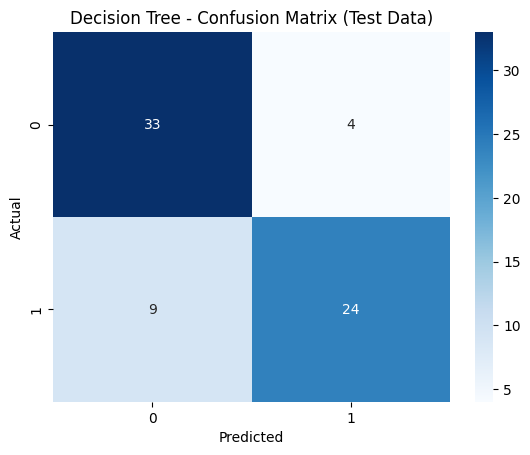

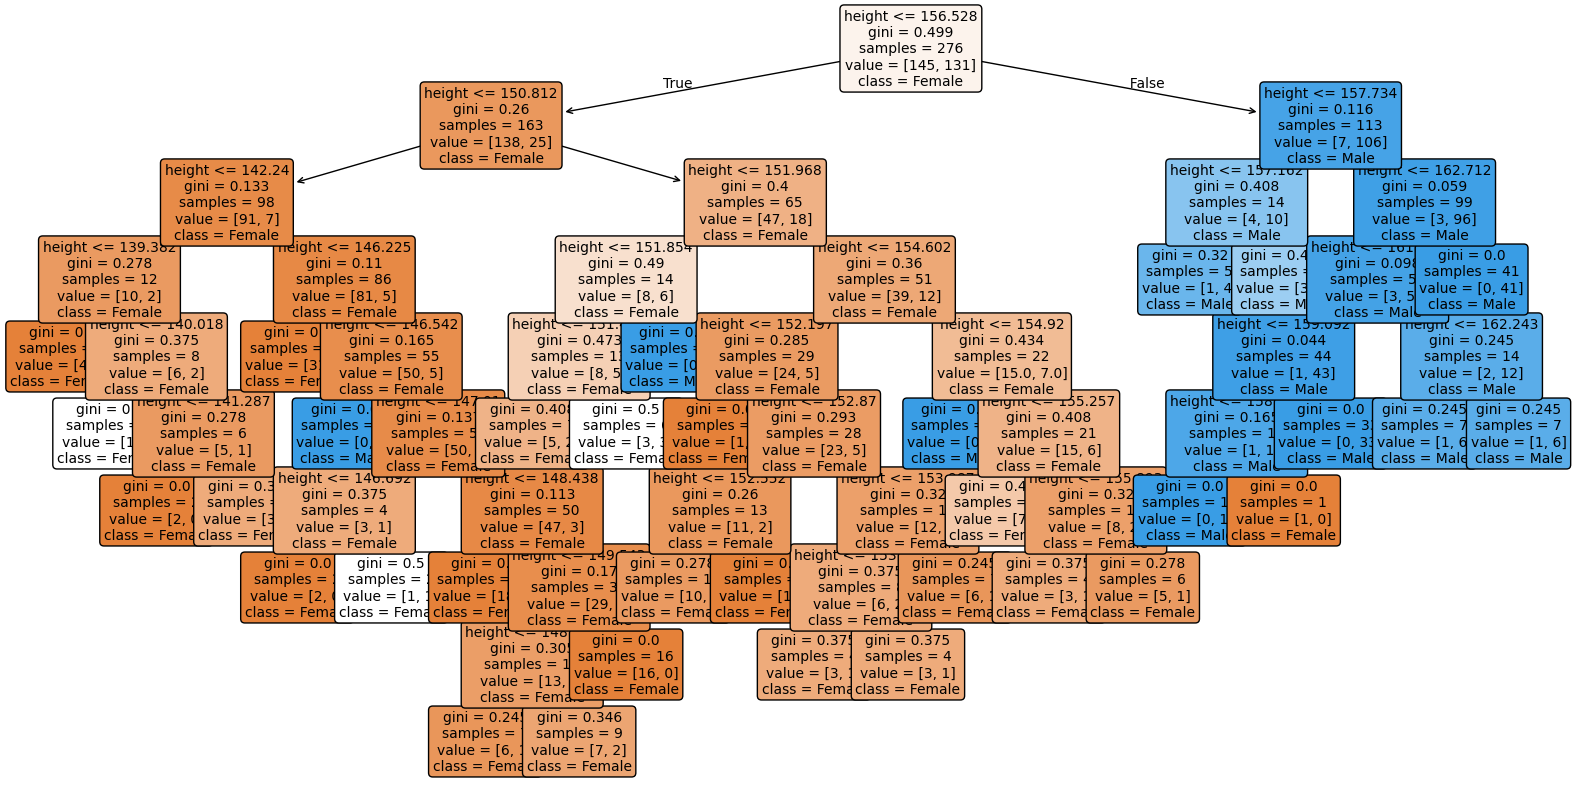

In [25]:
# --- Section 4: Train a Decision Tree Classifier ---

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 4.1 Split the data (Stratified to preserve male/female ratio)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

for train_idx, test_idx in splitter.split(X, y):
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")

# 4.2 Train the Decision Tree
tree_model = DecisionTreeClassifier(random_state=123)
tree_model.fit(X_train, y_train)

# 4.3 Evaluate on training data
y_train_pred = tree_model.predict(X_train)
print("\n Results for Decision Tree on training data:")
print(classification_report(y_train, y_train_pred,target_names=['Female','Male']))

# 4.4 Evaluate on test data
y_test_pred = tree_model.predict(X_test)
print("\n📈 Results for Decision Tree on test data:")
print(classification_report(y_test, y_test_pred, target_names=['Female', 'Male']))

# 4.5 Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title("Decision Tree - Confusion Matrix (Test Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 4.6 Plot the Decision Tree Structure
fig = plt.figure(figsize=(20,10))
plot_tree(
    tree_model,
    feature_names=X.columns,
    class_names=['Female', 'Male'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()


### Reflection 4  

- How well did the Decision Tree perform on the training and test data?  
- Do you notice any signs of overfitting (e.g., perfect training accuracy but lower test accuracy)?  
- Which feature combination (height, weight, or both) appears to give the best results?  
- What does the confusion matrix reveal about the types of errors the model makes?


## 🤖 Section 5: Compare Alternative Models (SVC and Neural Network)

In this section, we test two additional classifiers and compare their performance against the Decision Tree model.

1. **Support Vector Machine (SVC):**  
   - Finds the optimal boundary that separates the two classes (male vs. female).  
   - Often effective for linear or near-linear relationships.

2. **Neural Network (MLPClassifier):**  
   - Uses multiple hidden layers to learn complex, non-linear patterns.  
   - Can overfit small datasets but often achieves high accuracy after tuning.

We’ll use both **height and weight** as input features for these models.



🧩 Results for Support Vector Classifier (SVC):
              precision    recall  f1-score   support

      Female       0.78      0.78      0.78        37
        Male       0.76      0.76      0.76        33

    accuracy                           0.77        70
   macro avg       0.77      0.77      0.77        70
weighted avg       0.77      0.77      0.77        70



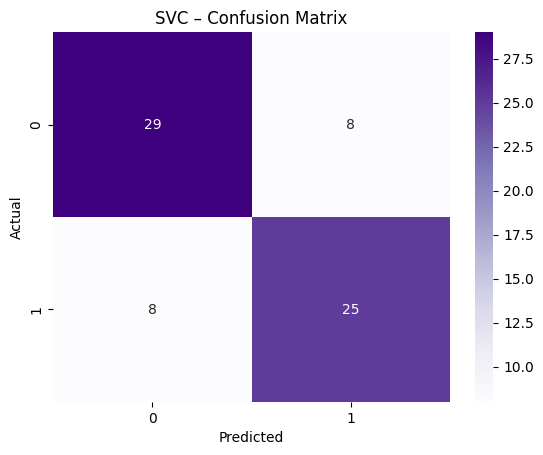

🤖 Results for Neural Network (MLP):
              precision    recall  f1-score   support

      Female       0.80      0.76      0.78        37
        Male       0.74      0.79      0.76        33

    accuracy                           0.77        70
   macro avg       0.77      0.77      0.77        70
weighted avg       0.77      0.77      0.77        70



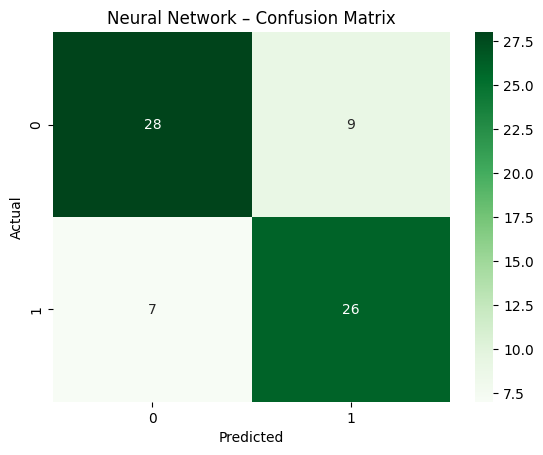

In [26]:
# --- Section 5: Alternative Models ---

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 5.1 Use Height + Weight as Features ---
X = howell_adults[['height', 'weight']]
y = howell_adults['male']

# --- 5.2 Train/Test Split (Reuse same method) ---
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx, test_idx in splitter.split(X, y):
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

# --- 5.3 Support Vector Classifier ---
svc_model = SVC(kernel='rbf', gamma='scale', C=1.0, random_state=123)
svc_model.fit(X_train, y_train)

y_pred_svc = svc_model.predict(X_test)
print("🧩 Results for Support Vector Classifier (SVC):")
print(classification_report(y_test, y_pred_svc, target_names=['Female', 'Male']))

cm_svc = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm_svc, annot=True, cmap='Purples', fmt='d')
plt.title("SVC – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- 5.4 Neural Network Model ---
nn_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10),
                         solver='lbfgs',
                         max_iter=2000,
                         random_state=123)
nn_model.fit(X_train, y_train)

y_pred_nn = nn_model.predict(X_test)
print("🤖 Results for Neural Network (MLP):")
print(classification_report(y_test, y_pred_nn, target_names=['Female', 'Male']))

cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True, cmap='Greens', fmt='d')
plt.title("Neural Network – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



### Reflection 5  

- How well did each model (SVC and Neural Network) perform compared to the Decision Tree?  
- Were the results surprising?  
- Which model generalized best to the test data?  
- Why might one algorithm outperform another on this dataset?  


## Section 6: Final Thoughts & Insights  

In this final section, we summarize model performance and interpret which predictors and algorithms worked best for distinguishing gender in the Howell dataset.  
We also discuss challenges, insights, and next steps for improving results.


### Model Performance Comparison  

| Model                                   | Input Features             | Train Accuracy | Test Accuracy | Notes |
|:---------------------------------------|:----------------------------|:---------------:|:--------------:|:------|
| Decision Tree (Case 1)                  | Height only                |  ≈ 0.90        |  ≈ 0.81        | Good performance; minor overfitting. |
| Decision Tree (Case 2)                  | Weight only                |  ___           |  ___           | Add your results. |
| Decision Tree (Case 3)                  | Height + Weight           |  ___           |  ___           | Add your results. |
| Support Vector Machine (SVC)          | Height + Weight           |  ___           |  ___           | Likely smoother boundary; better generalization. |
| Neural Network (MLPClassifier)       | Height + Weight           |  ___           |  ___           | More complex; risk of overfitting. |


### Reflection 6  

**1. What indicators are strong predictors of gender?**  
Height was the most important single feature. Adding weight helped slightly by refining the decision boundary.  

**2. Which model performed best overall?**  
(Write your observation here — for example, SVC and Neural Network performed similarly and both outperformed the Decision Tree on test data.)  

**3. Were there any surprising results?**  
(Discuss if you expected height to dominate or if weight had more impact than you thought.)  

**4. Challenges faced:**  
Small sample size and tight feature range can limit generalization.  
Balancing interpretability and accuracy is often a trade-off between Decision Trees and Neural Nets.  

**5. Next steps:**  
- Experiment with BMI as an additional feature.  
- Use hyperparameter tuning to adjust tree depth or SVC kernels.  
- Explore more features (e.g., age, bmi class) to see if patterns change.  
